# Applications of ML for Networking Final Project
---
#### Name: 劉耀文 (Yao-Wen Liu)
#### Student ID: 311551045
---

## Data Input and library import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import joblib

import warnings
warnings.filterwarnings("ignore")

column_name = ['NSS', 'MCS', 'GI', 'throughput', 'airtime_per', 'other_per']
dataset = pd.read_csv('network_trace.txt', sep=" ", names=column_name, header=None)
dataset

,NSS,MCS,GI,throughput,airtime_per,other_per
0,2,6,1,51.055077,0.075920,0.0
1,2,7,1,50.742508,0.093920,0.0
2,1,9,1,51.897148,0.093228,0.0
3,2,8,1,49.850716,0.095052,0.0
4,2,5,1,51.727776,0.100688,0.0
...,...,...,...,...,...,...
367,1,9,0,51.375793,0.136256,0.0
368,2,5,0,49.931450,0.107029,0.0
369,2,4,0,50.180573,0.124320,0.0
370,2,5,0,49.762260,0.108120,0.0


## Data Preprocessing
* Most of the preprocessing is done in the publisher.py / subscriber.py.
* The label is from the next second's throughput
    * If throughput >= 60 Mbps, then quality = 0 (1080p)
    * 60 > tp >= 40, quality = 1 (900p)
    * 40 > tp >= 30, quality = 2 (720p)
    * 30 > tp >= 20, quality = 3 (540p)
    * 20 > tp      , quality = 4 (360p)

In [2]:
label = [0]
for i in range(1, len(dataset)):
    if(dataset.at[i, 'throughput'] >= 50):
        label.append(0)
    elif(dataset.at[i, 'throughput'] >= 40):
        label.append(1)
    elif(dataset.at[i, 'throughput'] >= 30):
        label.append(2)
    elif(dataset.at[i, 'throughput'] >= 20):
        label.append(3)
    else:
        label.append(4)

dataset['label'] = label
dataset

print(label)

[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 2, 1, 2, 1, 2, 4, 3, 3, 4, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 3, 4, 3, 2, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 2, 1, 1, 2, 2, 3, 1, 1, 1, 3, 2, 2, 2, 1, 1, 1, 2, 2, 1, 3, 3, 3, 2, 4, 4, 2, 4, 4, 4, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 4, 3, 4, 4, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 4, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 3, 2, 2, 0, 1, 0, 1, 0, 1, 1, 1, 2, 3, 4, 3, 4, 4, 4, 4, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 3, 4, 3, 3, 3, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 1, 4, 4, 2, 1, 1, 3, 4, 3, 4, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 3, 

In [3]:
# drop first row because the label is not correct
dataset = dataset.drop(dataset.index[0], axis=0)

# drop the throughput column, which is replaced by the quality
dataset = dataset.drop(['throughput'], axis=1)

# Shuffle the data.
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset

,NSS,MCS,GI,airtime_per,other_per,label
0,1,7,0,0.123792,0.529323,1
1,1,4,0,0.276039,0.000000,2
2,1,5,1,0.230080,0.000000,1
3,2,2,0,0.179728,0.530399,4
4,2,8,1,0.060716,0.000000,0
...,...,...,...,...,...,...
366,2,2,1,0.143104,0.501871,4
367,2,1,1,0.213156,0.485016,4
368,2,7,1,0.092340,0.000000,0
369,1,5,1,0.102784,0.454679,3


## Data Visualization

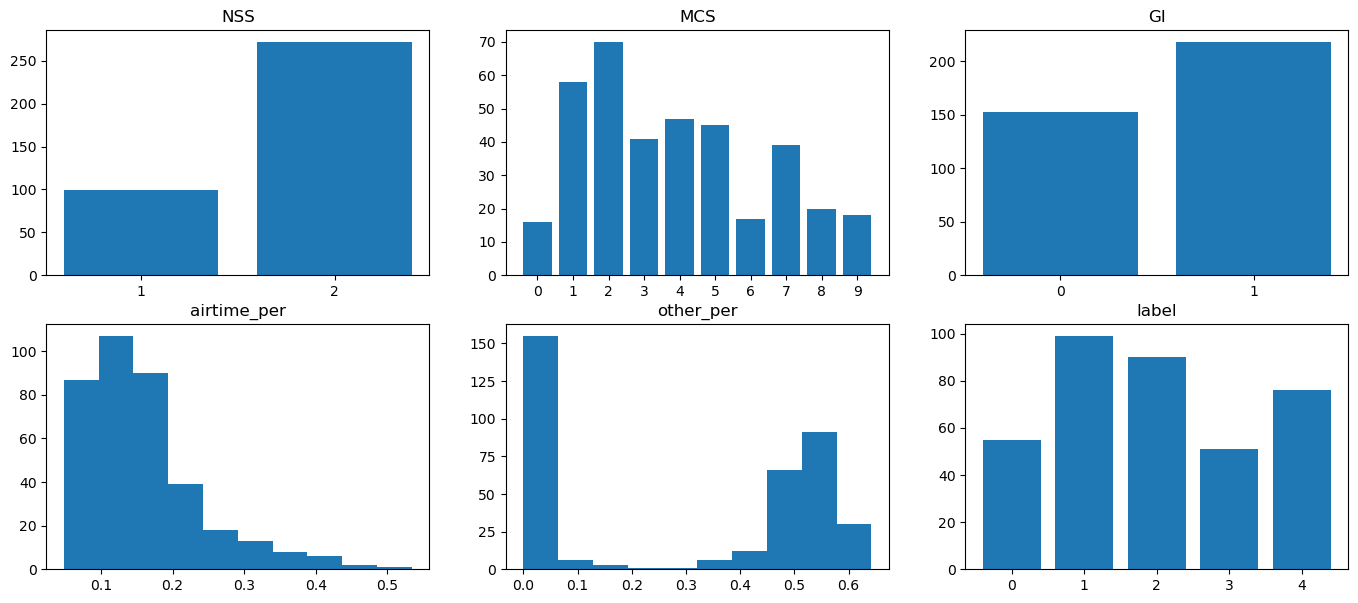

In [4]:
index = 0
plt.figure(figsize=(16.8, 7))
for feature in dataset:
    plt.subplot(2, 3, index + 1)
    # numeric features
    if feature == 'airtime_per' or feature == 'other_per':
        plt.hist(dataset[feature], bins=10, range=[dataset[feature].min(), dataset[feature].max()])
        plt.title(feature)
    # symbolic features
    else:
        tmp_col = dataset[feature].astype(str)
        labels, i=np.unique(tmp_col, return_index=True)
        counts=[]
        for j in range(0,len(labels)):
            counts.append(tmp_col.tolist().count(labels[j]))
        plt.bar(labels, counts)
        plt.title(feature)
    index += 1
plt.savefig('data_visualization.png', bbox_inches='tight')

## Model Construction and Performance
#### Decision Tree

In [5]:
y_train = dataset['label']
X_train = dataset.drop(['label'], axis=1)

k_fold = KFold(n_splits=3)
k_fold.get_n_splits(X_train)

iteration = 1
clf = DecisionTreeClassifier(criterion="entropy")
for train_index, validation_index in k_fold.split(X_train):
    x_train_cv, x_validation_cv = X_train.values[train_index], X_train.values[validation_index]
    y_train_cv, y_validation_cv = y_train[train_index], y_train[validation_index]
    
    clf.fit(x_train_cv, y_train_cv)
    y_predict_cv = clf.predict(x_validation_cv)
    
    print(f'iteration #{iteration} Recall: {recall_score(y_validation_cv, y_predict_cv, average=None)}')
    print(f'iteration #{iteration} Precision: {precision_score(y_validation_cv, y_predict_cv, average=None)}')
    print(f'iteration #{iteration} F1-Score: {f1_score(y_validation_cv, y_predict_cv, average=None)}')
    iteration += 1
    print()

iteration #1 Recall: [0.3125     0.51724138 0.46153846 0.5        0.54166667]
iteration #1 Precision: [0.45454545 0.39473684 0.52941176 0.4        0.61904762]
iteration #1 F1-Score: [0.37037037 0.44776119 0.49315068 0.44444444 0.57777778]

iteration #2 Recall: [0.42105263 0.43243243 0.5        0.26315789 0.69565217]
iteration #2 Precision: [0.36363636 0.47058824 0.40625    0.41666667 0.66666667]
iteration #2 F1-Score: [0.3902439  0.45070423 0.44827586 0.32258065 0.68085106]

iteration #3 Recall: [0.45       0.45454545 0.4        0.3125     0.72413793]
iteration #3 Precision: [0.5        0.44117647 0.35714286 0.3125     0.77777778]
iteration #3 F1-Score: [0.47368421 0.44776119 0.37735849 0.3125     0.75      ]



#### Performance

Recall: [0.8     0.81818 0.83333 0.78431 0.89474]
Precision: [0.83019 0.81    0.80645 0.78431 0.91892]
F1-Score: [0.81481 0.81407 0.81967 0.78431 0.90667]
Average: 0.82611, 0.82997, 0.82791


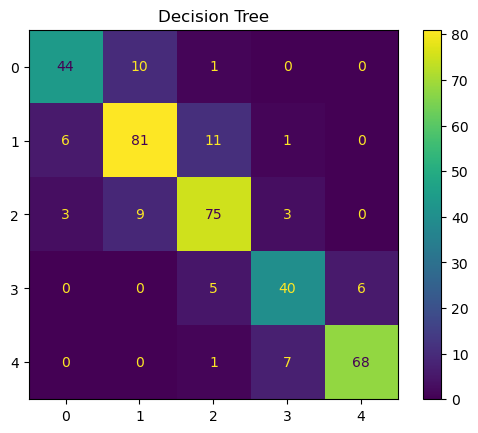

In [6]:
y_pred = clf.predict(X_train)

conf_matrix = confusion_matrix(y_true=y_train, y_pred=y_pred)

recall = recall_score(y_train, y_pred, average=None)
precision = precision_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average=None)

print(f'Recall: {np.round(recall, 5)}')
print(f'Precision: {np.round(precision, 5)}')
print(f'F1-Score: {np.round(f1, 5)}')
print(f'Average: {np.round(np.average(recall), 5)}, {np.round(np.average(precision), 5)}, {np.round(np.average(f1), 5)}')

titles = ['Decision Tree']
f, axes = plt.subplots()

for i in range(0,1):
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
    disp.plot(ax=axes)
    disp.ax_.set_title(titles[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')

f.colorbar(disp.im_, ax=axes)
plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.show()

## Modeling Saving
* Save the ML model as file to be imported by the adaptation module.

In [7]:
joblib.dump(clf, 'pre-trained_model')

['pre-trained_model']